# Master OOD Analysis Pipeline

This notebook implements the comprehensive Out-of-Distribution (OOD) analysis pipeline for the MACE Force Fields.

## Features
1. **Robust Checkpointing:** Caches expensive intermediate results to pickle.
2. **Exploratory Analysis:** Visualizes metric distributions before setting thresholds.
3. **Full Export:** Saves all metrics and flags to Excel/Pickle for downstream use.
4. **Dual Perspective:** Evaluates using both `MACE_T1` (Trained on T1) and `MACE_T2` (Trained on T3).

## Objectives
1. Identify "Intersection OODs": Structures that are anomalous to *both* T1 and T3 manifolds.



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ase.io import iread
from sklearn.covariance import EmpiricalCovariance
from sklearn.neighbors import NearestNeighbors
import pickle
import warnings

# Suppress expected warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
BASE_DIR = "/home/phanim/harshitrawat/summer/embeddings_results"
DATA_DIR = "/home/phanim/harshitrawat/summer/T1_T2_T3_data"
OUTPUT_DIR = "/home/phanim/harshitrawat/summer/OOD_Analysis_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset Files
DATASETS = {
    "T1": "T1_chgnet_labeled.extxyz",
    "T2": "T2_chgnet_labeled.extxyz",
    "T3": "T3_chgnet_labeled.extxyz"
}

# Helper to get embedding paths
def get_emb_paths(model_name, target_name):
    return [
        os.path.join(BASE_DIR, f"embeddings_{model_name}_w{i}_on_{target_name}.extxyz") 
        for i in range(1, 5)
    ]



## 1. Checkpointing Helper

This function ensures we don't re-compute expensive steps if the file already exists.



In [3]:
def load_or_compute(filename, func, *args, **kwargs):
    "Checks if filename exists in OUTPUT_DIR. If so, loads it. Else, runs func and saves."
    filepath = os.path.join(OUTPUT_DIR, filename)
    
    if os.path.exists(filepath):
        print(f"[CHECKPOINT] Found {filename}. Loading from disk...")
        if filename.endswith(".pkl"):
            return pd.read_pickle(filepath)
        elif filename.endswith(".csv"):
            return pd.read_csv(filepath)
    else:
        print(f"[COMPUTING] {filename} not found. Running processing...")
        result = func(*args, **kwargs)
        
        # Save based on type
        if filename.endswith(".pkl"):
            result.to_pickle(filepath)
        elif filename.endswith(".csv"):
            result.to_csv(filepath, index=False)
            
        print(f"[SAVED] Saved checkpoint to {filepath}")
        return result



## 2. Data Processing Logic
Streaming loader that computes pooled structure embeddings and ensemble variance.



In [4]:
def process_dataset_ensemble(target_name, model_name):
    print(f"--- Processing {model_name} on {target_name} ---")
    
    src_path = os.path.join(DATA_DIR, DATASETS[target_name])
    emb_paths = get_emb_paths(model_name, target_name)
    
    # Verify existence
    for p in [src_path] + emb_paths:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Missing file: {p}")
            
    # Generators
    gen_src = iread(src_path, index=":")
    gens_emb = [iread(p, index=":") for p in emb_paths]
    
    results = []
    count = 0
    
    # Iterate
    # Zip stops at shortest, which is fine as they should match
    for atoms_tuple in zip(gen_src, *gens_emb):
        src = atoms_tuple[0]
        embs = atoms_tuple[1:] # 4 atoms objects
        
        try:
            # Shape: (4, N_atoms, 128)
            latent_batch = np.stack([at.arrays["mace_latent"] for at in embs])
        except KeyError:
            print(f"Warning: 'mace_latent' missing in frame {count}. Skipping.")
            continue
            
        # 1. Structure Pooling (Mean over atoms, Mean over seeds)
        # Mean over Seeds -> (N_atoms, 128)
        mean_latent_atoms = np.mean(latent_batch, axis=0)
        # Mean over Atoms -> (128,)
        struct_latent = np.mean(mean_latent_atoms, axis=0)
        
        # 2. Uncertainty (Variance of Latents across seeds)
        # (4, N, 128) -> var(axis=0) -> (N, 128) -> mean -> scalar
        latent_var = np.var(latent_batch, axis=0).mean()
        
        # 3. Metadata
        fname = src.info.get("file", src.info.get("filename", f"unknown_{target_name}_{count}"))
        
        results.append({
            "filename": fname,
            "struct_latent": struct_latent,
            "latent_variance": latent_var,
            "dataset": target_name,
            "model": model_name
        })
        
        count += 1
        if count % 1000 == 0:
            print(f"Processed {count} structures...", end='\r')
            
    print(f"\nFinished {target_name} ({model_name}): {len(results)} structures.")
    return pd.DataFrame(results)



## 3. Load References & Fit Models
We load T1 (Ref A) and T3 (Ref B) and fit Mahalanobis/KNN models.



In [5]:
# Load References (Cached)
df_ref_A = load_or_compute("checkpoint_T1_MACE_T1.pkl", process_dataset_ensemble, "T1", "MACE_T1")
df_ref_B = load_or_compute("checkpoint_T3_MACE_T2.pkl", process_dataset_ensemble, "T3", "MACE_T2")

# Extract matricies
X_ref_A = np.stack(df_ref_A["struct_latent"].values)
X_ref_B = np.stack(df_ref_B["struct_latent"].values)

print(f"Reference A (T1) Shape: {X_ref_A.shape}")
print(f"Reference B (T3) Shape: {X_ref_B.shape}")

# Fit Models
print("Fitting Distance Models...")
cov_A = EmpiricalCovariance().fit(X_ref_A)
knn_A = NearestNeighbors(n_neighbors=5).fit(X_ref_A)

cov_B = EmpiricalCovariance().fit(X_ref_B)
knn_B = NearestNeighbors(n_neighbors=5).fit(X_ref_B)
print("Models Fitted.")



[CHECKPOINT] Found checkpoint_T1_MACE_T1.pkl. Loading from disk...
[CHECKPOINT] Found checkpoint_T3_MACE_T2.pkl. Loading from disk...
Reference A (T1) Shape: (6337, 256)
Reference B (T3) Shape: (1612, 256)
Fitting Distance Models...
Models Fitted.


## 4. Universal OOD Scoring
Compute distances for ALL datasets (T1, T2, T3) against BOTH references.



In [6]:
def compute_full_metrics():
    all_dfs = []
    
    for target in ["T1", "T2", "T3"]:
        print(f"\n=== Analyzing Target: {target} ===")
        
        # 1. Perspective A: MACE_T1
        # Use checkpoint if possible, else process
        df_A = load_or_compute(f"checkpoint_{target}_MACE_T1.pkl", process_dataset_ensemble, target, "MACE_T1")
        X_A = np.stack(df_A["struct_latent"].values)
        
        df_A["mahal_dist_A"] = cov_A.mahalanobis(X_A)
        dists_A, _ = knn_A.kneighbors(X_A)
        df_A["knn_dist_A"] = dists_A.mean(axis=1)
        
        # 2. Perspective B: MACE_T2
        df_B = load_or_compute(f"checkpoint_{target}_MACE_T2.pkl", process_dataset_ensemble, target, "MACE_T2")
        X_B = np.stack(df_B["struct_latent"].values)
        
        df_B["mahal_dist_B"] = cov_B.mahalanobis(X_B)
        dists_B, _ = knn_B.kneighbors(X_B)
        df_B["knn_dist_B"] = dists_B.mean(axis=1)
        
        # 3. Merge
        # We assume strict ordering.
        full_df = df_A.copy()
        full_df = full_df.rename(columns={"latent_variance": "var_A", "struct_latent": "latent_A"})
        
        full_df["var_B"] = df_B["latent_variance"]
        full_df["latent_B"] = df_B["struct_latent"]
        full_df["mahal_dist_B"] = df_B["mahal_dist_B"]
        full_df["knn_dist_B"] = df_B["knn_dist_B"]
        
        # Consolidated 'latent_variance' (use max or mean? Let's keep both, but maybe max is safer for "Any Model Uncertain")
        # For simplicity, we'll keep both var_A and var_B.
        
        all_dfs.append(full_df)
        
    return pd.concat(all_dfs, ignore_index=True)

# Run Analysis
global_df = compute_full_metrics()
print(f"\nTotal Structures Analyzed: {len(global_df)}")




=== Analyzing Target: T1 ===
[CHECKPOINT] Found checkpoint_T1_MACE_T1.pkl. Loading from disk...
[CHECKPOINT] Found checkpoint_T1_MACE_T2.pkl. Loading from disk...

=== Analyzing Target: T2 ===
[CHECKPOINT] Found checkpoint_T2_MACE_T1.pkl. Loading from disk...
[CHECKPOINT] Found checkpoint_T2_MACE_T2.pkl. Loading from disk...

=== Analyzing Target: T3 ===
[COMPUTING] checkpoint_T3_MACE_T1.pkl not found. Running processing...
--- Processing MACE_T1 on T3 ---
Processed 1000 structures...
Finished T3 (MACE_T1): 1612 structures.
[SAVED] Saved checkpoint to /home/phanim/harshitrawat/summer/OOD_Analysis_Output/checkpoint_T3_MACE_T1.pkl
[CHECKPOINT] Found checkpoint_T3_MACE_T2.pkl. Loading from disk...

Total Structures Analyzed: 8654


## 5. Exploratory Metric Analysis
Before defining OOD thresholds, we inspect the distributions of all metrics to see how T1, T2, and T3 behave.



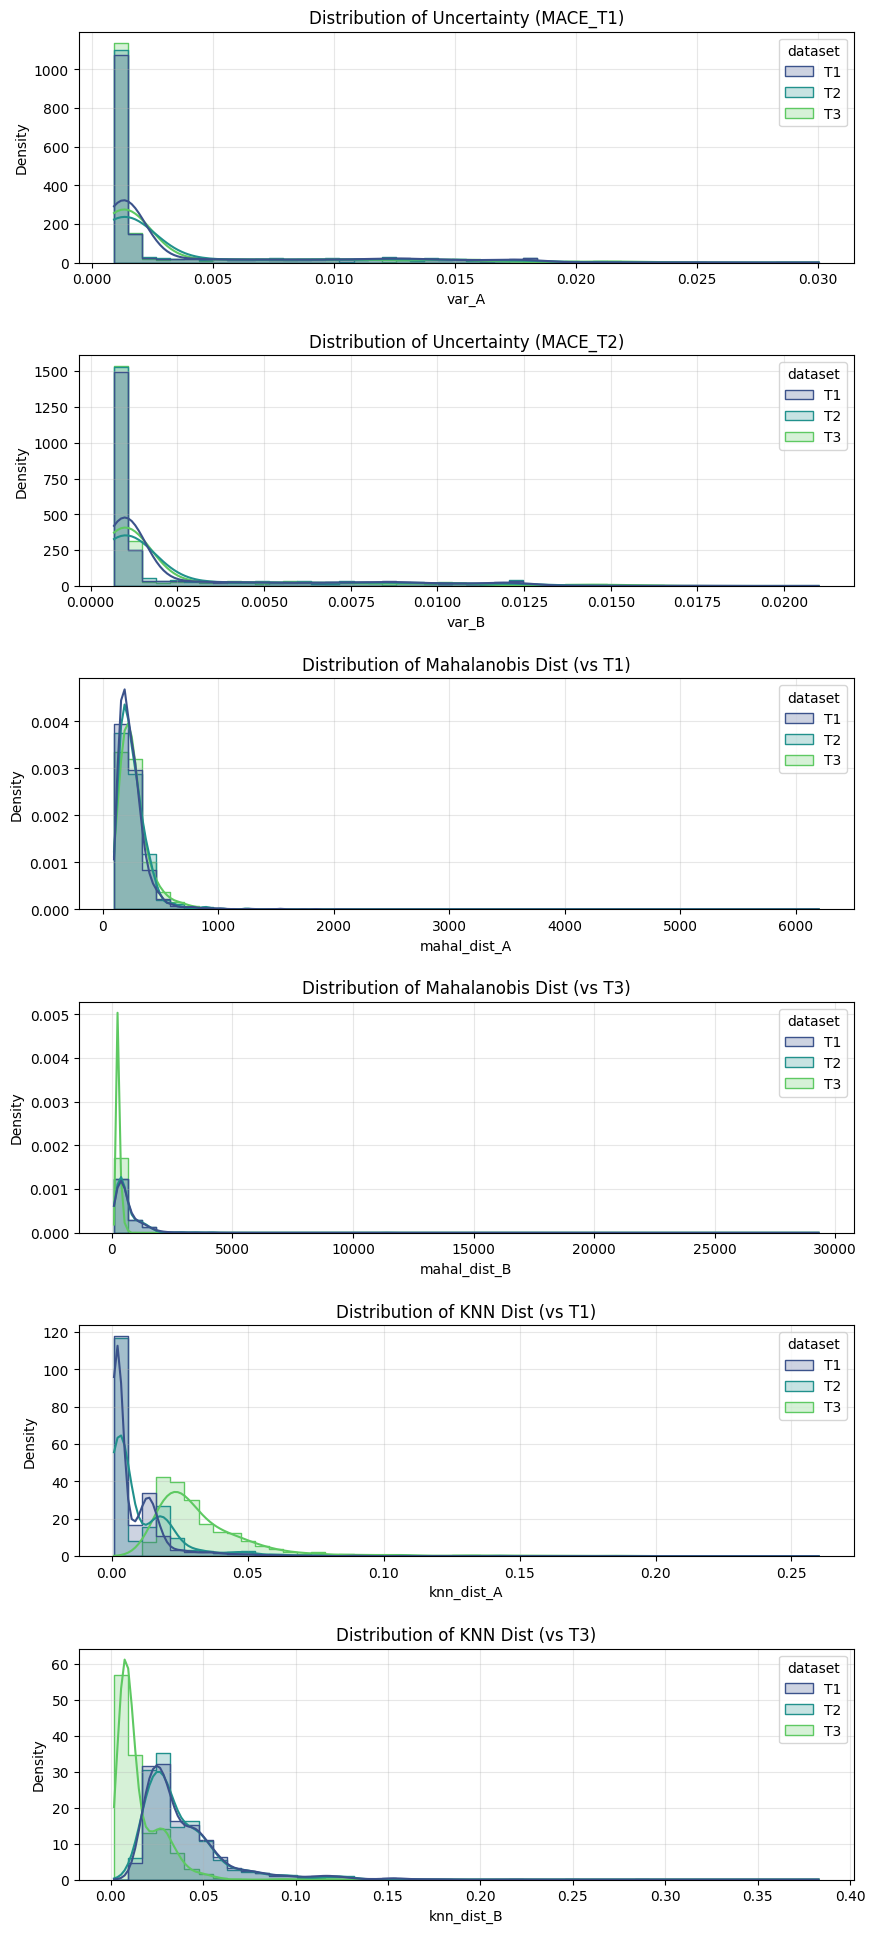

In [7]:
# Define metrics to plot
metrics_to_plot = [
    ("var_A", "Uncertainty (MACE_T1)"),
    ("var_B", "Uncertainty (MACE_T2)"),
    ("mahal_dist_A", "Mahalanobis Dist (vs T1)"),
    ("mahal_dist_B", "Mahalanobis Dist (vs T3)"),
    ("knn_dist_A", "KNN Dist (vs T1)"),
    ("knn_dist_B", "KNN Dist (vs T3)")
]

# Plot Histograms
fig, axes = plt.subplots(nrows=len(metrics_to_plot), ncols=1, figsize=(10, 4 * len(metrics_to_plot)))
plt.subplots_adjust(hspace=0.4)

for i, (col, name) in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.histplot(
        data=global_df, x=col, hue="dataset", 
        element="step", stat="density", common_norm=False, 
        bins=50, kde=True, ax=ax, palette="viridis"
    )
    ax.set_title(f"Distribution of {name}")
    ax.grid(True, alpha=0.3)

plt.savefig(os.path.join(OUTPUT_DIR, "Exploratory_Metric_Distributions.png"))
plt.show()



## 6. Full Data Export
We save the entire dataset (metrics + metadata) to Excel/Pickle so you can analyze individual structures without re-running.



In [8]:
# Save Full Pickle (includes latent vectors)
full_pkl_path = os.path.join(OUTPUT_DIR, "Master_OOD_Global_Results.pkl")
global_df.to_pickle(full_pkl_path)
print(f"Full Pickle saved to: {full_pkl_path}")

# Save Excel (Exclude vectors for readability)
full_excel_path = os.path.join(OUTPUT_DIR, "Master_OOD_Global_Metric_Summary.xlsx")
cols_to_save = [c for c in global_df.columns if "latent" not in c] # Exclude vectors
# Keep variances though, they typically have 'variance' in name but are scalars.
# 'latent_A' and 'latent_B' are the vectors.

cols_export = [c for c in global_df.columns if isinstance(global_df[c].iloc[0], (int, float, str, bool, np.number))]
global_df[cols_export].to_excel(full_excel_path, index=False)
print(f"Full Excel summary saved to: {full_excel_path}")



Full Pickle saved to: /home/phanim/harshitrawat/summer/OOD_Analysis_Output/Master_OOD_Global_Results.pkl
Full Excel summary saved to: /home/phanim/harshitrawat/summer/OOD_Analysis_Output/Master_OOD_Global_Metric_Summary.xlsx


## 7. Top Outliers (Exploration)
We verify the top 20 outliers per metric to sanity check the results.



In [ ]:
# Helper to show top outliers
def show_top_outliers(metric_col, n=20):
    subset = global_df.sort_values(metric_col, ascending=False).head(n)
    return subset[["filename", "dataset", metric_col]]

with pd.ExcelWriter(os.path.join(OUTPUT_DIR, "Top_Outliers_Report.xlsx")) as writer:
    for col, name in metrics_to_plot:
        top_df = show_top_outliers(col)
        sheet_name = name.replace(" ", "_").replace("(", "").replace(")", "")[:30]
        top_df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Saved top outliers for {name}")
        
print("Top outliers report generated.")

